In [1]:
import pandas as pd
import numpy as np
from pyproj import Proj
from scipy.spatial import cKDTree
from netCDF4 import Dataset
from datetime import datetime, timedelta

class RealWind:
    def __init__(self, start_date="2019-10-01", num_days=9):
        """
        Precompute and store wind data in a pandas DataFrame for fast lookup.
        The table includes time (in minutes), northing, easting, U (east wind), and V (north wind).
        """
        self.proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
        self.wind_table = []  # List to accumulate wind data

        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        layer_range = (56, 68)  # Height range for averaging wind speeds
        bounding_box = (140.5, -39, 150, -34)

        for day_offset in range(num_days):
            current_date = start_date + timedelta(days=day_offset)
            date_str = current_date.strftime('%Y%m%d')
            file_path = rf"C:\\Users\\Nur Izfarwiza\\Documents\\Dissertation\\Wind\\MERRA2_400.tavg3_3d_asm_Nv.{date_str}.nc4"

            try:
                dataset = Dataset(file_path, 'r')
                lats = dataset.variables['lat'][:]
                lons = dataset.variables['lon'][:]
                
                # Apply the bounding box filter
                lat_indices = np.where((lats >= bounding_box[1]) & (lats <= bounding_box[3]))[0]
                lon_indices = np.where((lons >= bounding_box[0]) & (lons <= bounding_box[2]))[0]

                lats = lats[lat_indices]
                lons = lons[lon_indices]

                # Load and filter wind data within the bounding box
                eastward_wind = dataset.variables['U'][:, :, lat_indices, :][:, :, :, lon_indices]
                northward_wind = dataset.variables['V'][:, :, lat_indices, :][:, :, :, lon_indices]

                # Average over the specified vertical layers
                layer_range_slice = slice(layer_range[0], layer_range[1])
                eastward_wind_avg = np.mean(eastward_wind[:, layer_range_slice, :, :], axis=1)
                northward_wind_avg = np.mean(northward_wind[:, layer_range_slice, :, :], axis=1)

                # Read and store time directly in minutes
                print("NASA Time Units:", dataset.variables['time'].units)
                time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!

                for t_idx, t_val in enumerate(time_var):
                    if not np.isfinite(t_val):
                        continue  # Skip invalid time values
                    timestamp = t_val  # Store time directly in minutes

                    # Vectorized coordinate transformation
                    lon_grid, lat_grid = np.meshgrid(lons, lats)
                    easting, northing = self.proj(lon_grid, lat_grid)

                    # Flatten arrays to create a table of points
                    easting = easting.flatten()
                    northing = northing.flatten()
                    u_wind = eastward_wind_avg[t_idx].flatten()
                    v_wind = northward_wind_avg[t_idx].flatten()

                    # Filter out invalid projections
                    valid_mask = np.isfinite(easting) & np.isfinite(northing) & np.isfinite(u_wind) & np.isfinite(v_wind)

                    # Append valid data to the wind table
                    self.wind_table.extend(
                        zip([timestamp] * np.sum(valid_mask),
                            northing[valid_mask],
                            easting[valid_mask],
                            u_wind[valid_mask],
                            v_wind[valid_mask])
                    )

                dataset.close()

            except FileNotFoundError:
                print(f"File for {date_str} not found.")
            except Exception as e:
                print(f"Error loading {date_str}: {e}")

        # Convert to pandas DataFrame for fast lookups
        self.wind_table = pd.DataFrame(self.wind_table, columns=["Timestamp", "Northing", "Easting", "East Wind", "North Wind"])

        # Clean data: Drop NaN or Inf values
        self.wind_table = self.wind_table.replace([np.inf, -np.inf], np.nan)
        self.wind_table = self.wind_table.dropna()

        # Sort by timestamp for faster temporal queries
        self.wind_table = self.wind_table.sort_values(by="Timestamp").reset_index(drop=True)

        # Build a spatial KD-Tree for efficient spatial querying
        self.wind_tree = cKDTree(self.wind_table[["Easting", "Northing"]].values)

        print(f"Wind data precomputed for {len(self.wind_table)} points across {num_days} days.")
    
    def getwind(self, coords):
        """
        Get the nearest-neighbor wind speed for particles at given positions and times.

        Parameters:
        - coords: A tensor of shape (num_particles, num_observations, 3)
                  where each entry is [time, easting, northing].

        Returns:
        - wind_data: A tensor of shape (num_particles, num_observations, 2)
                     where each entry is [east_wind_speed, north_wind_speed].
        """
        num_particles, num_observations, _ = coords.shape
        wind_data = np.full((num_particles, num_observations, 2), np.nan)  # Initialize with NaN

        timestamps = coords[:, :, 0].flatten()  # Keep time in minutes

        for i in range(num_particles):
            for j in range(num_observations):
                easting, northing = coords[i, j, 1], coords[i, j, 2]
                timestamp = timestamps[i * num_observations + j]

                closest_time_idx = (np.abs(self.wind_table["Timestamp"] - timestamp)).idxmin()
                dist, closest_idx = self.wind_tree.query([easting, northing], k=1)

                wind_data[i, j] = self.wind_table.loc[closest_idx, ["East Wind", "North Wind"]]

        return wind_data


In [2]:
windmodel = RealWind(start_date="2019-10-01", num_days=2)

NASA Time Units: minutes since 2019-10-01 01:30:00


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_21820\706863214.py:49: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_21820\706863214.py:49: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!


NASA Time Units: minutes since 2019-10-02 01:30:00
Wind data precomputed for 2816 points across 2 days.


# Placing Particles for Visualisation

In [3]:
# Open dataset
file_path = rf"C:\\Users\\Nur Izfarwiza\\Documents\\Dissertation\\Wind\\MERRA2_400.tavg3_3d_asm_Nv.20191001.nc4"
dataset = Dataset(file_path, 'r')

# Extract lat, lon, and check their shapes
lats = dataset.variables['lat'][:]      # (361,)
lons = dataset.variables['lon'][:]      # (576,)
U = dataset.variables['U'][:]           # (time, level, lat, lon)
V = dataset.variables['V'][:]

# Bounding box over Australia (lon_min, lat_min, lon_max, lat_max)
bounding_box = (140.5, -39, 150, -34)

# Get lat/lon indices within the bounding box
lat_indices = np.where((lats >= bounding_box[1]) & (lats <= bounding_box[3]))[0]
lon_indices = np.where((lons >= bounding_box[0]) & (lons <= bounding_box[2]))[0]
print("Selected Latitude Indices:", lat_indices)
print("Selected Longitude Indices:", lon_indices)

# Optional: Select a specific vertical level or average over a range
level_range = slice(56, 68)  # Example height range

# Subset wind data (this preserves time and level dimensions)
subset_U = U[:, level_range, lat_indices, :][:, :, :, lon_indices]
subset_V = V[:, level_range, lat_indices, :][:, :, :, lon_indices]

# Average over vertical levels (axis=1)
subset_U_avg = np.mean(subset_U, axis=1)
subset_V_avg = np.mean(subset_V, axis=1)

# Prepare grids for projection
subset_lats = lats[lat_indices]
subset_lons = lons[lon_indices]
lon_grid, lat_grid = np.meshgrid(subset_lons, subset_lats)
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
eastings, northings = proj(lon_grid, lat_grid)


Selected Latitude Indices: [102 103 104 105 106 107 108 109 110 111 112]
Selected Longitude Indices: [513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528]


In [4]:
from shapely.geometry import Polygon
grid_size = 1.0  # 1 degree per grid cell
lat_bins = np.arange(bounding_box[1], bounding_box[3] + grid_size, grid_size)
lon_bins = np.arange(bounding_box[0], bounding_box[2] + grid_size, grid_size)
grid_polygons = []
for i in range(len(lat_bins) - 1):
    for j in range(len(lon_bins) - 1):
        # Define grid cell corners
        coords = np.array([
            [eastings[i, j], northings[i, j]],  # Bottom-left
            [eastings[i+1, j], northings[i+1, j]],  # Top-left
            [eastings[i+1, j+1], northings[i+1, j+1]],  # Top-right
            [eastings[i, j+1], northings[i, j+1]],  # Bottom-right
            [eastings[i, j], northings[i, j]]  # Close the loop
        ])
        
        # Create polygon
        grid_polygons.append(Polygon(coords))

# Print first polygon
print("First Grid Polygon Coordinates:", grid_polygons[0].exterior.coords[:])


First Grid Polygon Coordinates: [(-573278.8742603282, 5609644.646183068), (-580936.6221402239, 5665399.129582861), (-526173.6083182422, 5672685.144901696), (-518917.39488908567, 5616956.285822747), (-573278.8742603282, 5609644.646183068)]


In [5]:
import pointpats

# Store all particle points
particles = []

for polygon in grid_polygons:
    # Generate 10 random points within each polygon
    pts = pointpats.random.poisson(polygon, size=10)
    particles.append(pts)

# Convert particles into an array
particles = np.vstack(particles)  # Stack all generated points

# Print first few particles
print("Generated Particles:\n", particles[:10])

Generated Particles:
 [[-559257.79297141 5614233.85530224]
 [-574069.55618553 5634711.61161288]
 [-541488.65334056 5655508.09984244]
 [-565892.5747955  5651513.42869724]
 [-564036.2741486  5636815.62992598]
 [-571263.9936849  5621543.21209973]
 [-577918.74765501 5651856.75514391]
 [-556791.90704599 5655562.98273275]
 [-547603.30167553 5655345.16564412]
 [-536696.56199346 5663699.45746137]]


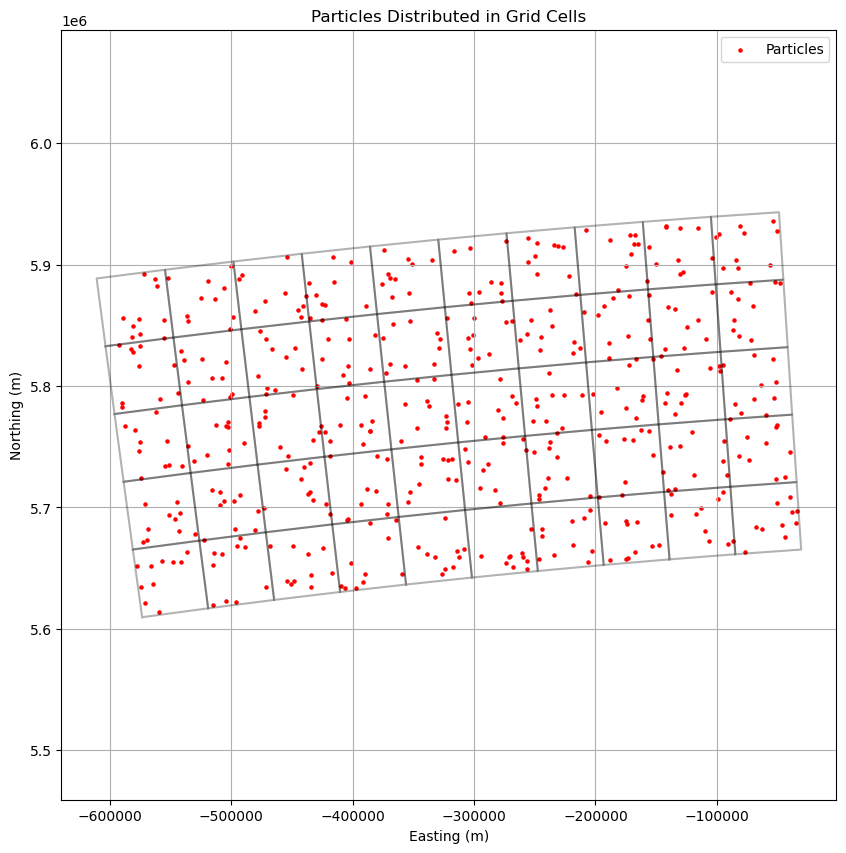

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Plot all grid polygons
for poly in grid_polygons:
    x, y = poly.exterior.xy
    plt.plot(x, y, 'k-', alpha=0.3)

# Plot particles
plt.scatter(particles[:, 0], particles[:, 1], color='red', s=5, label="Particles")

plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.title("Particles Distributed in Grid Cells")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


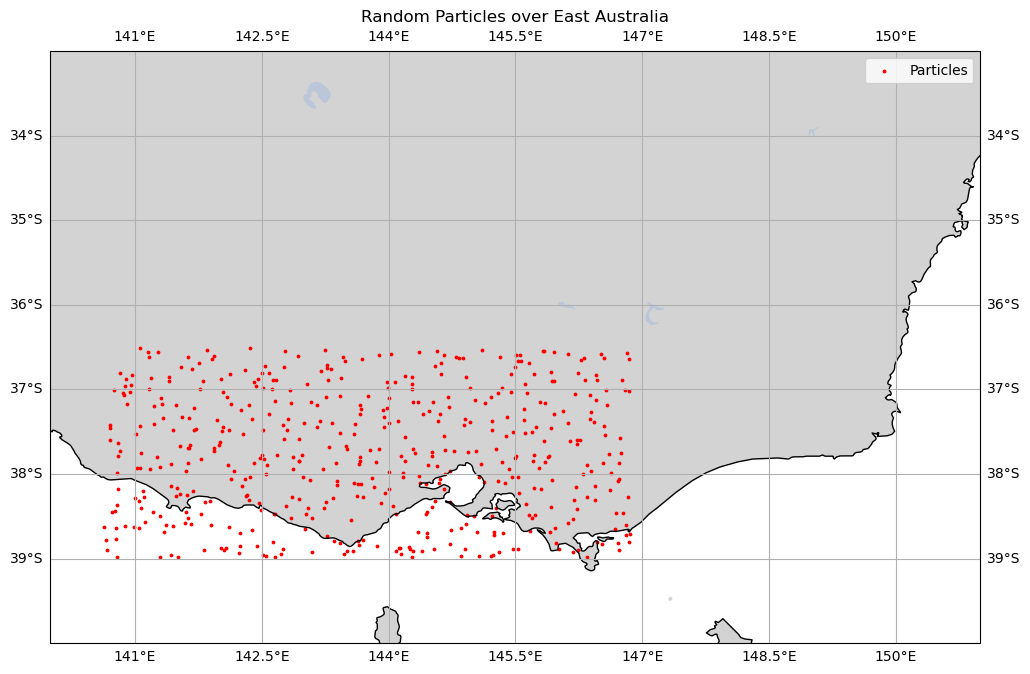

In [7]:
from pyproj import Transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Convert UTM to lat/lon
transformer = Transformer.from_crs("epsg:32756", "epsg:4326", always_xy=True)
lons, lats = transformer.transform(particles[:, 0], particles[:, 1])

# Plot with cartopy
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140, 151, -40, -33])  # East Australia

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.LAKES, alpha=0.4)
ax.gridlines(draw_labels=True)

# Plot particle points
ax.scatter(lons, lats, color='red', s=3, transform=ccrs.PlateCarree(), label="Particles")

plt.title("Random Particles over East Australia")
plt.legend()
plt.show()


# Testing t,x,y of the Wind Model

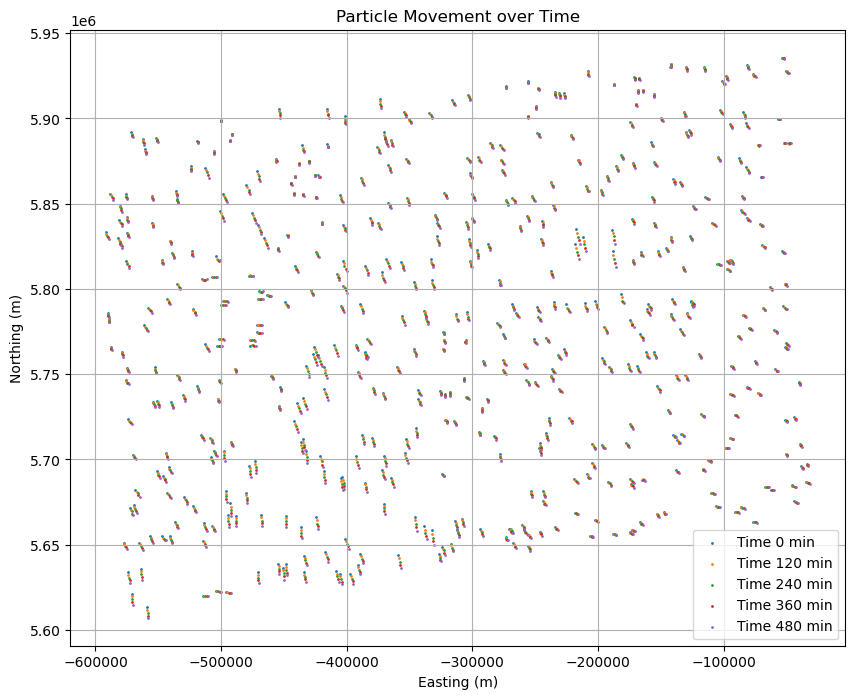

In [8]:
# Add a time column (start at t = 0 minutes)
initial_time = 0
particles_with_time = np.hstack([np.full((particles.shape[0], 1), initial_time), particles])  # shape (N, 3)
particles_with_time = particles_with_time[:, np.newaxis, :]  # Shape: (N, 1, 3)
import matplotlib.pyplot as plt

tstep = 60  # 60 minutes = 1 hour
steps = 10  # number of time steps
k_0 = 100  # diffusion coefficient

plt.figure(figsize=(10, 8))

for step in range(steps):
    # Get wind at current particle locations
    wind = windmodel.getwind(particles_with_time)  # shape (N, 1, 2)
    
    # Extract current positions
    positions = particles_with_time[:, 0, 1:]  # shape (N, 2)

    # Add advection (wind)
    positions += wind[:, 0, :] * tstep

    # Add diffusion
    noise = np.random.randn(*positions.shape) * np.sqrt(2 * k_0 * tstep)
    positions += noise

    # Update positions and time in particles_with_time
    particles_with_time[:, 0, 1:] = positions
    particles_with_time[:, 0, 0] += tstep  # update time

    # Plot positions at this step
    if step % 2 == 0:  # plot every few steps
        plt.scatter(positions[:, 0], positions[:, 1], s=1, label=f'Time {step * tstep} min')

plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Particle Movement over Time')
plt.legend()
plt.grid(True)
plt.show()


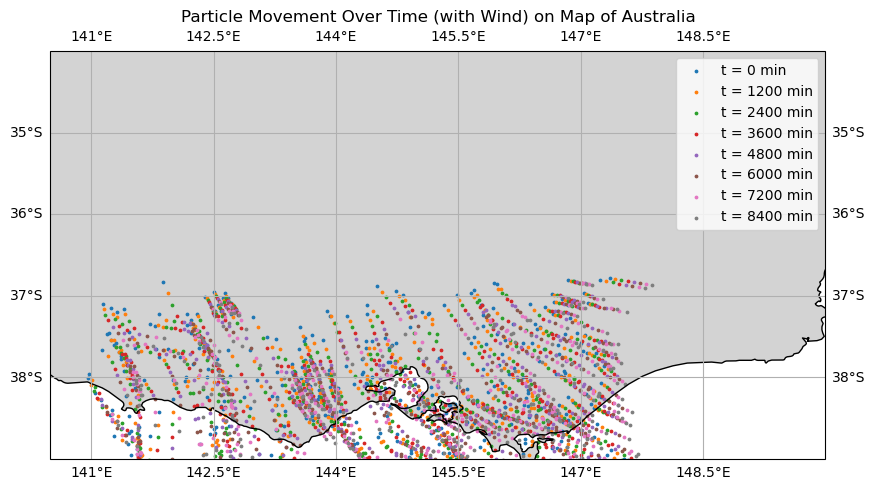

In [10]:
from pyproj import Transformer

# Create a transformer from UTM Zone 56S to WGS84 (lat/lon)
transformer_to_latlon = Transformer.from_crs("epsg:32756", "epsg:4326", always_xy=True)
lon, lat = transformer_to_latlon.transform(
    particles_with_time[:, 0, 1],  # easting
    particles_with_time[:, 0, 2]   # northing
)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

tstep = 600  # in secs
steps = 16
k_0 = 100

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140.5, 150, -39, -34])  # Victoria

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.gridlines(draw_labels=True)

for step in range(steps):
    # Get wind
    wind = windmodel.getwind(particles_with_time)  # shape (N, 1, 2)
    
    # Update positions
    particles_with_time[:, 0, 1:] += wind[:, 0, :] * tstep
    particles_with_time[:, 0, 1:] += np.random.randn(*particles_with_time[:, 0, 1:].shape) * np.sqrt(2 * tstep * k_0)
    particles_with_time[:, 0, 0] += tstep/60  # update time

    # Convert to lat/lon
    lon, lat = transformer_to_latlon.transform(
        particles_with_time[:, 0, 1],  # easting
        particles_with_time[:, 0, 2]   # northing
    )

    # Plot every few steps
    if step % 2 == 0:
        ax.scatter(lon, lat, s=3, label=f"t = {step * tstep} min")

plt.legend()
plt.title("Particle Movement Over Time (with Wind) on Map of Australia")
plt.show()


# Testing num_observations

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_61652\3893452273.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_observations)


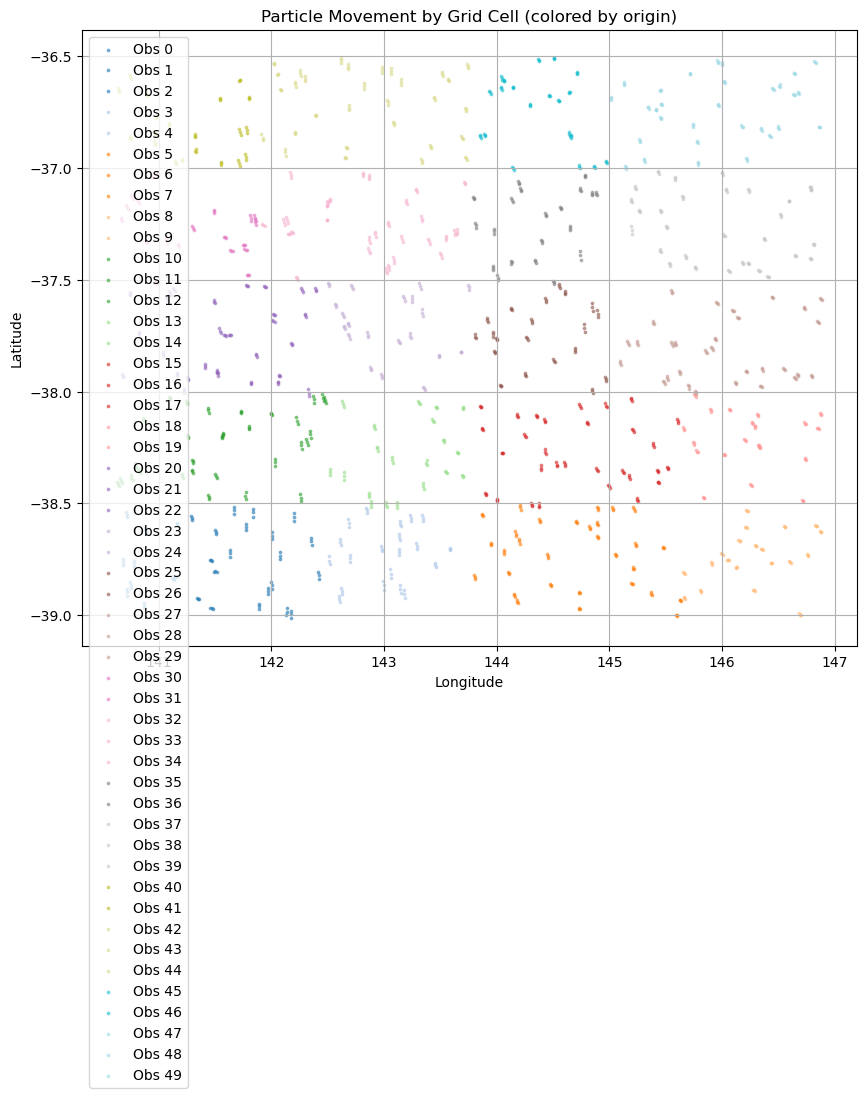

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer

# Setup
num_observations = len(grid_polygons)  # Each grid cell is a sensor
num_particles = 10
tstep = 60
steps = 5
k_0 = 100

# 1. Generate Particles With Time = 0
particles = []
for polygon in grid_polygons:
    pts = pointpats.random.poisson(polygon, size=num_particles)
    particles.append(pts)
particles_array = np.array(particles)  # (num_observations, num_particles, 2)

# 2. Add Time Column (all zeros initially)
initial_time = np.zeros((num_observations, num_particles, 1))
particles_tensor = np.concatenate([initial_time, particles_array], axis=2)  # shape: (obs, part, 3)

# 3. Setup Projection for Mapping
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
transformer = Transformer.from_proj(proj, "epsg:4326", always_xy=True)

# 4. Plot Setup
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab20', num_observations)

# 5. Loop over time steps
for step in range(steps):
    for obs in range(num_observations):
        # Slice particles for this observation
        p = particles_tensor[obs:obs+1, :, :]  # shape: (1, N, 3)

        wind = windmodel.getwind(p)  # shape: (1, N, 2)
        particles_tensor[obs, :, 1:] += wind[0] * tstep
        particles_tensor[obs, :, 1:] += np.random.randn(num_particles, 2) * np.sqrt(2 * k_0 * tstep)
        particles_tensor[obs, :, 0] += tstep

        # Plot subset
        if step % 2 == 0:
            east = particles_tensor[obs, :, 1]
            north = particles_tensor[obs, :, 2]
            lon, lat = transformer.transform(east, north)
            plt.scatter(lon, lat, s=3, alpha=0.5, color=colors(obs), label=f"Obs {obs}" if step == 0 else "")

# Final plot
plt.title("Particle Movement by Grid Cell (colored by origin)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend()
plt.show()


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_14340\444381225.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_observations)


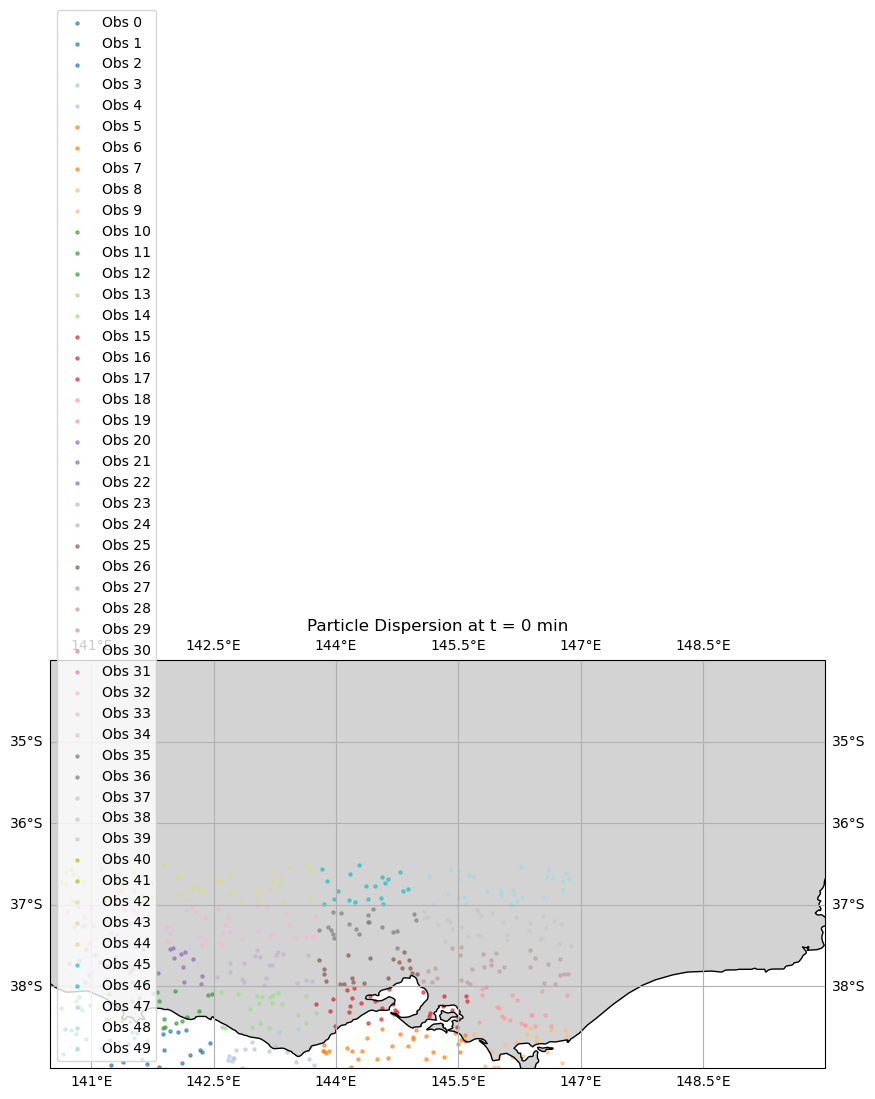

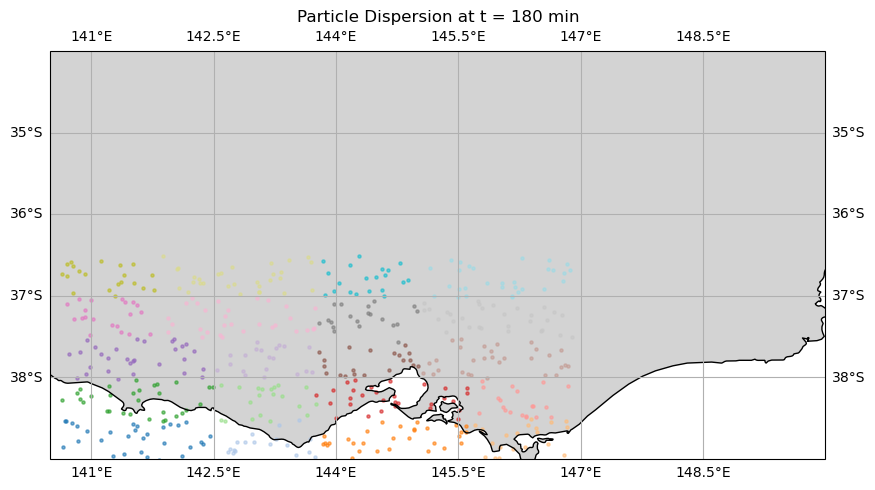

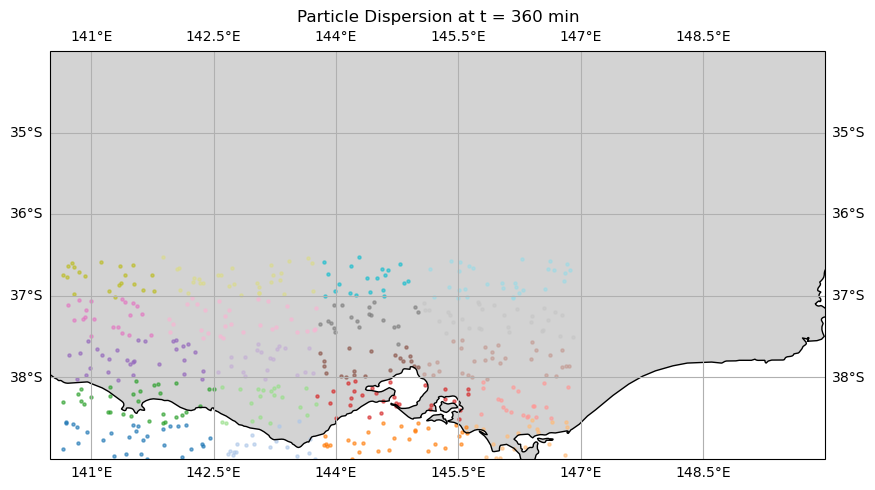

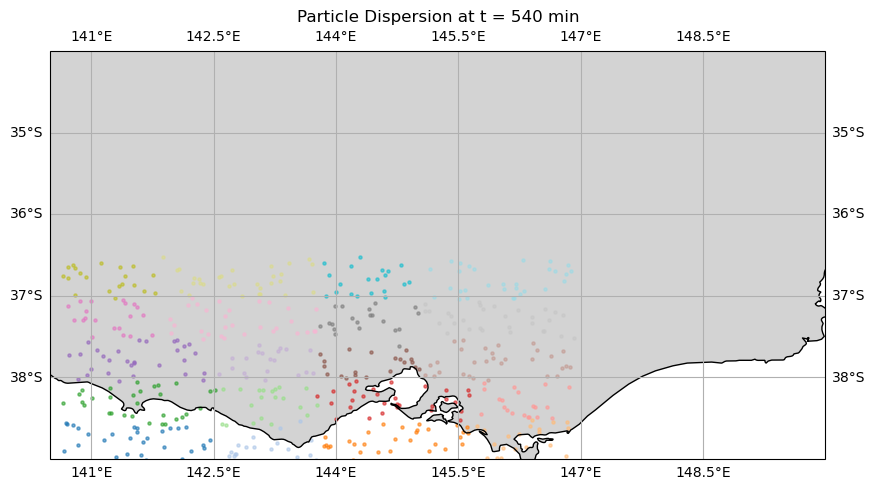

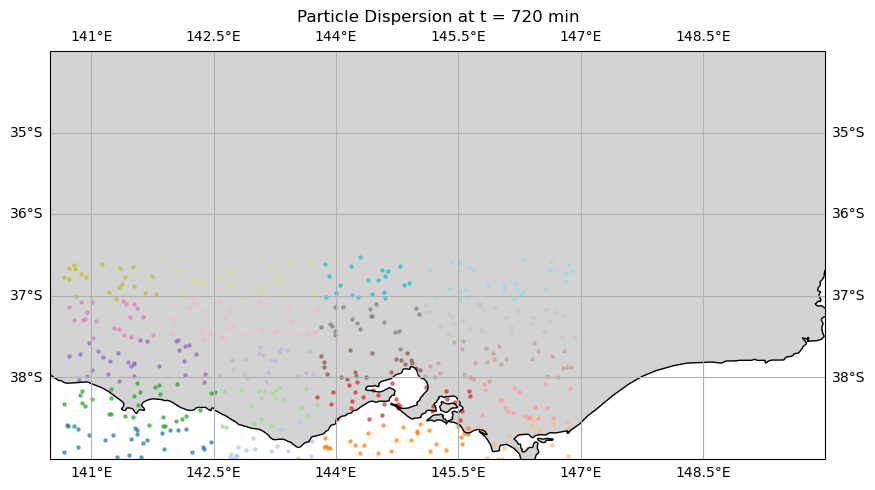

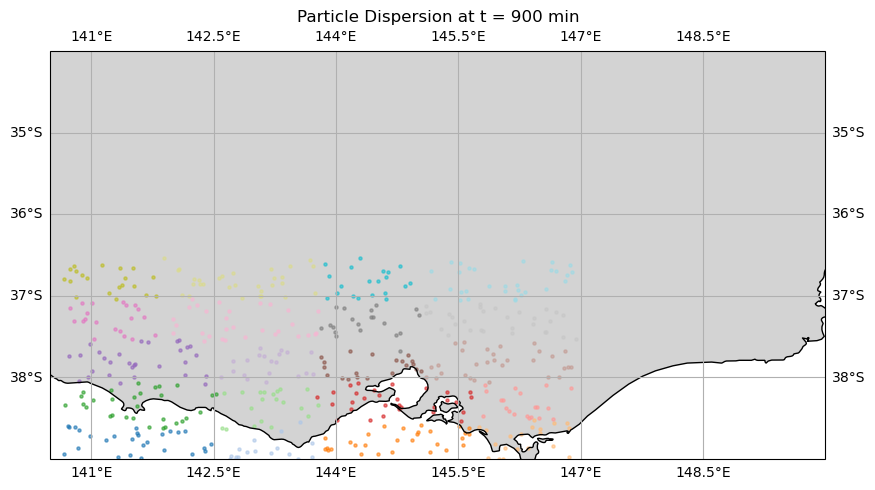

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj, Transformer

# Set constants
num_observations = len(grid_polygons)
num_particles = 10
tstep = 180  # in minutes
steps = 6
k_0 = 100  # diffusion coefficient

# Projection to lat/lon
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
transformer = Transformer.from_proj(proj, "epsg:4326", always_xy=True)

# Generate particles inside each polygon
particles = []
for poly in grid_polygons:
    pts = pointpats.random.poisson(poly, size=num_particles)
    particles.append(pts)
particles = np.array(particles)  # shape: (obs, particles, 2)

# Add time dimension (t=0)
time_zeros = np.zeros((num_observations, num_particles, 1))
particles_tensor = np.concatenate([time_zeros, particles], axis=2)  # shape (obs, part, 3)

# Plot on Cartopy
cmap = plt.cm.get_cmap('tab20', num_observations)

for step in range(steps):
    # Create map
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([140.5, 150, -39, -34])  # Victoria bounding box

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.gridlines(draw_labels=True)

    # Iterate over observations (grid cells)
    for obs_id in range(num_observations):
        # Extract particle block
        p = particles_tensor[obs_id:obs_id+1, :, :]  # shape: (1, N, 3)

        # Get wind
        wind = windmodel.getwind(p)  # (1, N, 2)
        particles_tensor[obs_id, :, 1:] += wind[0] * tstep
        particles_tensor[obs_id, :, 1:] += np.random.randn(num_particles, 2) * np.sqrt(2 * k_0 * tstep)
        particles_tensor[obs_id, :, 0] += tstep

        # Convert to lon/lat
        easting = particles_tensor[obs_id, :, 1]
        northing = particles_tensor[obs_id, :, 2]
        lon, lat = transformer.transform(easting, northing)

        # Plot
        ax.scatter(lon, lat, color=cmap(obs_id), s=5, alpha=0.6, label=f"Obs {obs_id}" if step == 0 else None)

    plt.title(f"Particle Dispersion at t = {step * tstep} min")
    if step == 0:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='lower left')

    plt.show()
